In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
import yfinance as yf
my_year_month_fmt = mdates.DateFormatter('%m/%y')

In [17]:
tic = ['^GSPC', 'SPY']
# ticker = yf.Ticker(tic)
# hist = ticker.history(period='10y')
hist = yf.download(tic, period='10y')['Adj Close']
# df = hist[['Open','High','Low','Close','Volume']]
hist.to_pickle('data.pkl')
data = pd.read_pickle('./data.pkl')
# data.columns = ['Open','High','Low', tic,'Volume']


data.head()

[*********************100%***********************]  2 of 2 completed


,SPY,^GSPC
Date,,
2011-01-06,104.397934,1273.849976
2011-01-07,104.193031,1271.500000
2011-01-10,104.061905,1269.750000
2011-01-11,104.430672,1274.479980
2011-01-12,105.373146,1285.959961


In [18]:
# Calculating the short-window simple moving average
short_rolling = data.rolling(window=20).mean()
short_rolling.head(20)

,SPY,^GSPC
Date,,
2011-01-06,NaN,NaN
2011-01-07,NaN,NaN
2011-01-10,NaN,NaN
2011-01-11,NaN,NaN
2011-01-12,NaN,NaN
2011-01-13,NaN,NaN
2011-01-14,NaN,NaN
2011-01-18,NaN,NaN
2011-01-19,NaN,NaN


In [19]:
# Calculating the long-window simple moving average
long_rolling = data.rolling(window=100).mean()
long_rolling.tail()

,SPY,^GSPC
Date,,
2020-12-29,346.287412,3486.236702
2020-12-30,346.689096,3490.044302
2020-12-31,347.099762,3494.000303
2021-01-04,347.487000,3497.669902
2021-01-05,347.853619,3501.135002


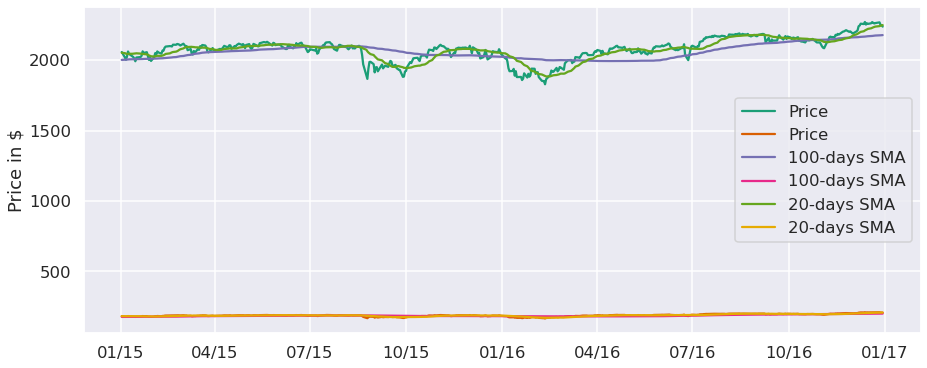

In [20]:
start_date = '2015-01-01'
end_date = '2016-12-31'

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, tic], label='Price')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, tic], label = '100-days SMA')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, tic], label = '20-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.xaxis.set_major_formatter(my_year_month_fmt);

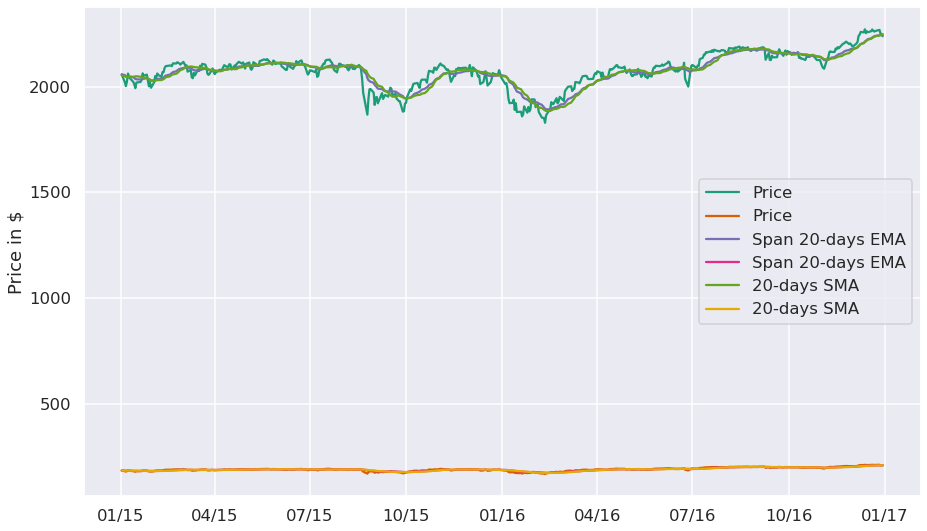

In [21]:
# Using Pandas to calculate a 20-days span EMA. adjust=False specifies that we are interested in the recursive calculation mode.
ema_short = data.ewm(span=20, adjust=False).mean()

fig, ax = plt.subplots(figsize=(15,9))

ax.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, tic], label='Price')
ax.plot(ema_short.loc[start_date:end_date, :].index, ema_short.loc[start_date:end_date, tic], label = 'Span 20-days EMA')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, tic], label = '20-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.xaxis.set_major_formatter(my_year_month_fmt);

In [22]:
# Taking the difference between the prices and the EMA timeseries
trading_positions_raw = data - ema_short
trading_positions_raw.tail()

,SPY,^GSPC
Date,,
2020-12-29,5.051725,47.274450
2020-12-30,5.050131,47.295931
2020-12-31,6.279180,64.533011
2021-01-04,1.075928,8.244955
2021-01-05,3.271534,31.173716


In [23]:
# Taking the sign of the difference to determine whether the price or the EMA is greater and then multiplying by 1/3
trading_positions = trading_positions_raw.apply(np.sign) * 1/3
trading_positions.tail()

,SPY,^GSPC
Date,,
2020-12-29,0.333333,0.333333
2020-12-30,0.333333,0.333333
2020-12-31,0.333333,0.333333
2021-01-04,0.333333,0.333333
2021-01-05,0.333333,0.333333


In [24]:
# Lagging our trading signals by one day.
trading_positions_final = trading_positions.shift(1)

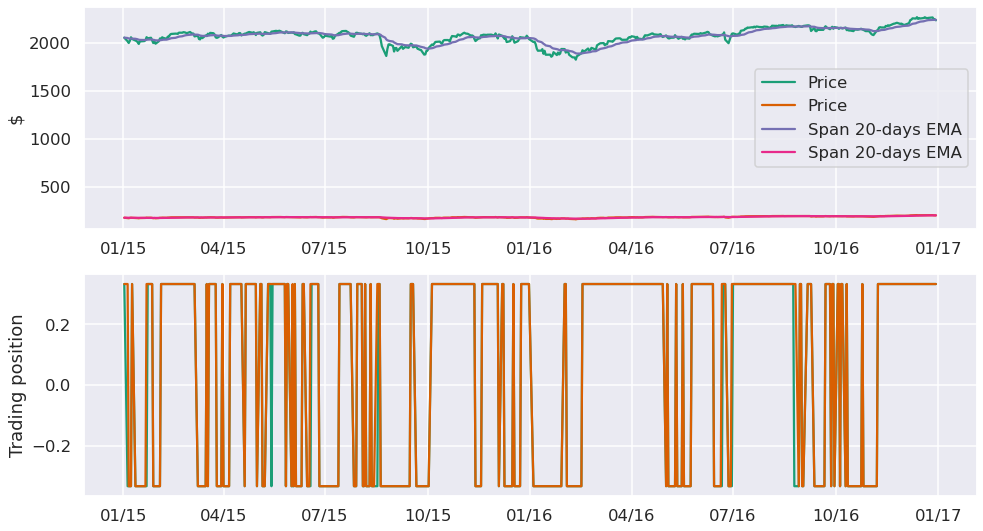

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

ax1.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, tic], label='Price')
ax1.plot(ema_short.loc[start_date:end_date, :].index, ema_short.loc[start_date:end_date, tic], label = 'Span 20-days EMA')

ax1.set_ylabel('$')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)

ax2.plot(trading_positions_final.loc[start_date:end_date, :].index, trading_positions_final.loc[start_date:end_date, tic], 
        label='Trading position')

ax2.set_ylabel('Trading position')
ax2.xaxis.set_major_formatter(my_year_month_fmt);

In [26]:
# Log returns - First the logarithm of the prices is taken and the the difference of consecutive (log) observations
asset_log_returns = np.log(data).diff()
asset_log_returns.head()

,SPY,^GSPC
Date,,
2011-01-06,NaN,NaN
2011-01-07,-0.001965,-0.001846
2011-01-10,-0.001259,-0.001377
2011-01-11,0.003537,0.003718
2011-01-12,0.008984,0.008967


In [27]:
strategy_asset_log_returns = trading_positions_final * asset_log_returns
strategy_asset_log_returns.tail()

,SPY,^GSPC
Date,,
2020-12-29,-0.000637,-0.000743
2020-12-30,0.000475,0.000447
2020-12-31,0.001689,0.002139
2021-01-04,-0.004569,-0.004955
2021-01-05,0.002288,0.002353


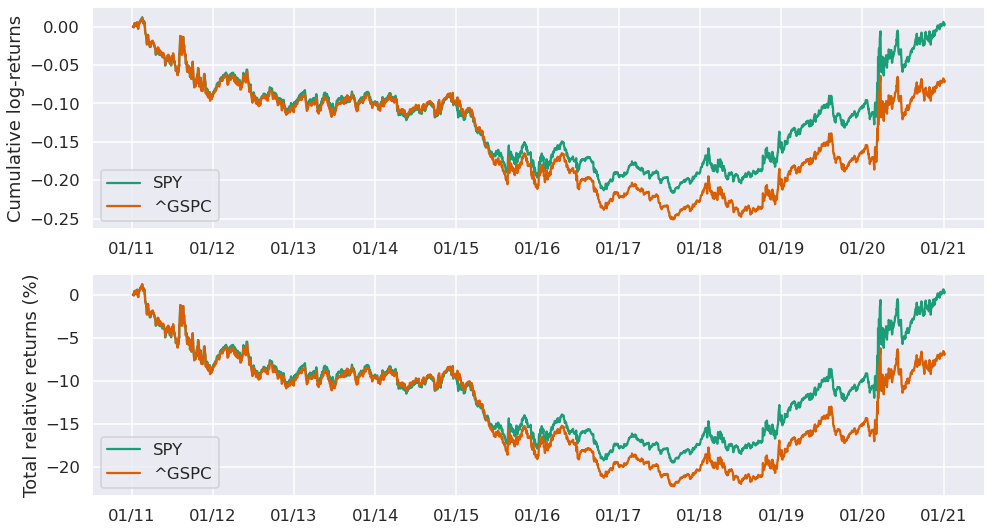

In [28]:
# Get the cumulative log-returns per asset
cum_strategy_asset_log_returns = strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
cum_strategy_asset_relative_returns = np.exp(cum_strategy_asset_log_returns) - 1

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

for c in asset_log_returns:
    ax1.plot(cum_strategy_asset_log_returns.index, cum_strategy_asset_log_returns[c], label=str(c))

ax1.set_ylabel('Cumulative log-returns')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)

for c in asset_log_returns:
    ax2.plot(cum_strategy_asset_relative_returns.index, 100*cum_strategy_asset_relative_returns[c], label=str(c))

ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')
ax2.xaxis.set_major_formatter(my_year_month_fmt);

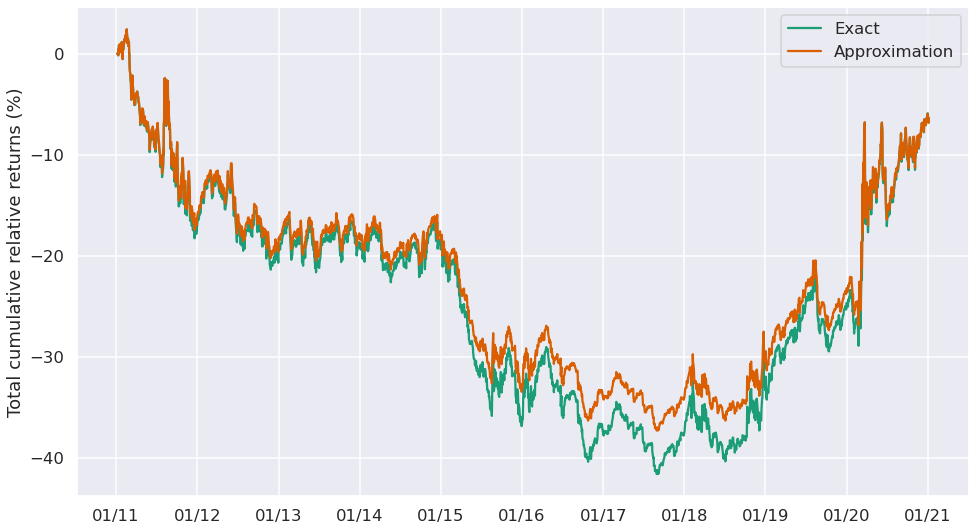

In [29]:
# Total strategy relative returns. This is the exact calculation.
cum_relative_return_exact = cum_strategy_asset_relative_returns.sum(axis=1)

# Get the cumulative log-returns per asset
cum_strategy_log_return = cum_strategy_asset_log_returns.sum(axis=1)

# Transform the cumulative log returns to relative returns. This is the approximation
cum_relative_return_approx = np.exp(cum_strategy_log_return) - 1

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(cum_relative_return_exact.index, 100*cum_relative_return_exact, label='Exact')
ax.plot(cum_relative_return_approx.index, 100*cum_relative_return_approx, label='Approximation')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
ax.xaxis.set_major_formatter(my_year_month_fmt);

In [30]:
def print_portfolio_yearly_statistics(portfolio_cumulative_relative_returns, days_per_year = 52 * 5):

    total_days_in_simulation = portfolio_cumulative_relative_returns.shape[0]
    number_of_years = total_days_in_simulation / days_per_year

    # The last data point will give us the total portfolio return
    total_portfolio_return = portfolio_cumulative_relative_returns[-1]
    # Average portfolio return assuming compunding of returns
    average_yearly_return = (1 + total_portfolio_return)**(1/number_of_years) - 1

    print('Total portfolio return is: ' + '{:5.2f}'.format(100*total_portfolio_return) + '%')
    print('Average yearly return is: ' + '{:5.2f}'.format(100*average_yearly_return) + '%')

print_portfolio_yearly_statistics(cum_relative_return_exact)

Total portfolio return is: -6.37%
Average yearly return is: -0.68%


Total portfolio return is: 95.67%
Average yearly return is:  7.18%


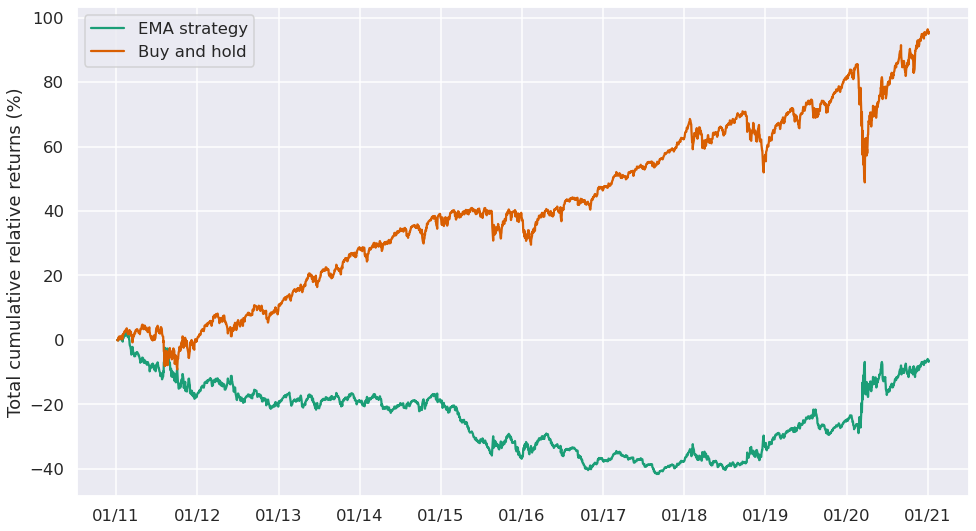

In [31]:
# Define the weights matrix for the simple buy-and-hold strategy
simple_weights_matrix = pd.DataFrame(1/3, index = data.index, columns=data.columns)

# Get the buy-and-hold strategy log returns per asset
simple_strategy_asset_log_returns = simple_weights_matrix * asset_log_returns

# Get the cumulative log-returns per asset
simple_cum_strategy_asset_log_returns = simple_strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
simple_cum_strategy_asset_relative_returns = np.exp(simple_cum_strategy_asset_log_returns) - 1

# Total strategy relative returns. This is the exact calculation.
simple_cum_relative_return_exact = simple_cum_strategy_asset_relative_returns.sum(axis=1)

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(cum_relative_return_exact.index, 100*cum_relative_return_exact, label='EMA strategy')
ax.plot(simple_cum_relative_return_exact.index, 100*simple_cum_relative_return_exact, label='Buy and hold')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
ax.xaxis.set_major_formatter(my_year_month_fmt)

print_portfolio_yearly_statistics(simple_cum_relative_return_exact);